In [ ]:
import pandas as pd
import numpy as np
%pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\Nazar\AppData\Local\Temp\ipykernel_16316\1760388023.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Index_DOSW_P{i}'] = df[f'P_WWZ_DOSW_P{i}'] / (df[f'P_WWB_DOSW_P{i}'])
C:\Users\Nazar\AppData\Local\Temp\ipykernel_16316\1760388023.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Index_NDOSW_P{i}'] = df[f'P_WWZ_NDOSW_P{i}'] / (df[f'P_WWB_NDOSW_P{i}'])
C:\Users\Nazar\AppData\Local\Temp\ipykernel_16316\1760388023.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

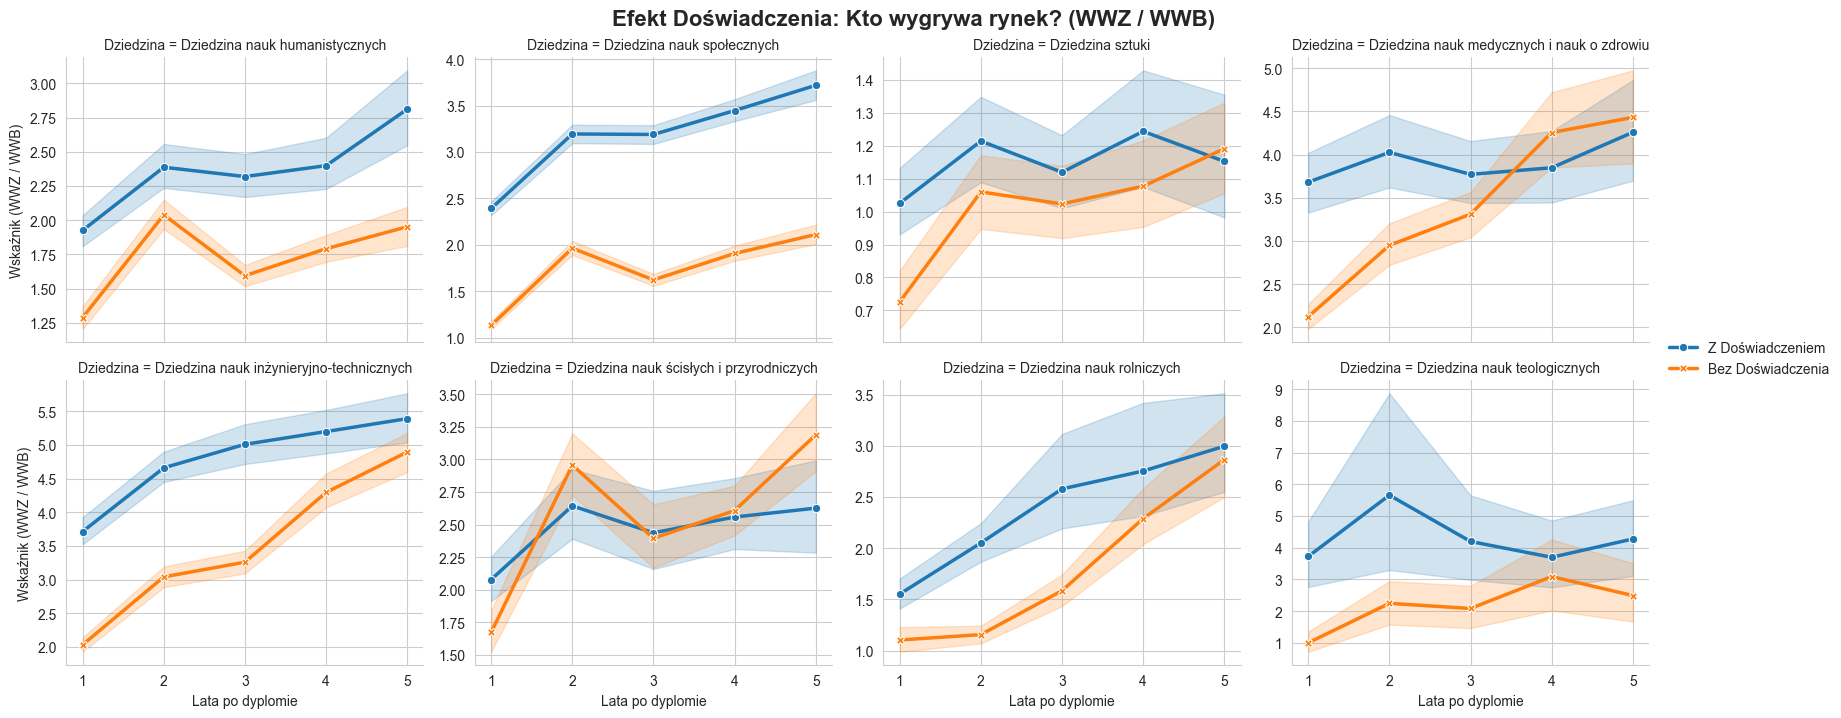


--- GDZIE DOŚWIADCZENIE DAJE NAJWIĘKSZEGO KOPA? (Rok 5) ---
P_DZIEDZINA
Dziedzina nauk humanistycznych               NaN
Dziedzina nauk inżynieryjno-technicznych     NaN
Dziedzina nauk medycznych i nauk o zdrowiu   NaN
Dziedzina nauk rolniczych                    NaN
Dziedzina nauk społecznych                   NaN
Dziedzina nauk teologicznych                 NaN
Dziedzina nauk ścisłych i przyrodniczych     NaN
Dziedzina sztuki                             NaN
Name: Premia_Doswiadczenia_P5, dtype: float64


C:\Users\Nazar\AppData\Local\Temp\ipykernel_16316\1760388023.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Premia_Doswiadczenia_P5'] = df['Index_DOSW_P5'] - df['Index_NDOSW_P5']


In [42]:
# --- 1. WCZYTANIE DANYCH (Słownik w głowie: P_WWZ_DOSW_P1 itd.) ---
data_dir = Path('./data') # Dostosuj ścieżkę
file_path = data_dir / 'graduates-major-data.csv'

# Kolumny, które nas interesują (Zarobki i Bezrobocie dla obu grup)
cols_base = ['P_DZIEDZINA', 'P_NAZWA_UCZELNI']
cols_dosw = [f'P_WWZ_DOSW_P{i}' for i in range(1, 6)] + [f'P_WWB_DOSW_P{i}' for i in range(1, 6)]
cols_ndosw = [f'P_WWZ_NDOSW_P{i}' for i in range(1, 6)] + [f'P_WWB_NDOSW_P{i}' for i in range(1, 6)]
cols_monthly = [f'P_WWZ_MIES_{i}' for i in range(1, 61)] + [f'P_WWB_MIES_{i}' for i in range(1, 61)]

# Bezpieczne wczytywanie
df = pd.read_csv(
    file_path, 
    usecols=cols_base + cols_dosw + cols_ndosw + cols_monthly, 
    sep=';', decimal=',', encoding='utf-8', on_bad_lines='skip'
)

# Konwersja na liczby (na wszelki wypadek)
for c in cols_dosw + cols_ndosw + cols_monthly:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# --- 2. OBLICZENIE NOWEGO WSKAŹNIKA (Return / Risk) ---
# Uwaga: Dodajemy mały epsilon (0.01) do mianownika, żeby nie dzielić przez zero
epsilon = 0.01

for i in range(1, 6):
    # Grupa Z DOŚWIADCZENIEM
    df[f'Index_DOSW_P{i}'] = df[f'P_WWZ_DOSW_P{i}'] / (df[f'P_WWB_DOSW_P{i}'])
    
    # Grupa BEZ DOŚWIADCZENIA
    df[f'Index_NDOSW_P{i}'] = df[f'P_WWZ_NDOSW_P{i}'] / (df[f'P_WWB_NDOSW_P{i}'])
    
for i in range(1, 61):
    # Grupa Z DOŚWIADCZENIEM
    df[f'IndexMIES_{i}'] = df[f'P_WWZ_MIES_{i}'] / (df[f'P_WWB_MIES_{i}'])

# --- 3. PRZYGOTOWANIE DO WIZUALIZACJI (Melt) ---
# Chcemy porównać te dwie grupy na jednym wykresie

# Tworzymy dwa tymczasowe DataFrame'y i je sklejamy
df_d = df[['P_DZIEDZINA'] + [f'Index_DOSW_P{i}' for i in range(1, 6)]].copy()
df_d.columns = ['Dziedzina'] + [str(i) for i in range(1, 6)] # Zmieniamy nazwy kolumn na lata 1-5
df_d['Status'] = 'Z Doświadczeniem'

df_n = df[['P_DZIEDZINA'] + [f'Index_NDOSW_P{i}' for i in range(1, 6)]].copy()
df_n.columns = ['Dziedzina'] + [str(i) for i in range(1, 6)]
df_n['Status'] = 'Bez Doświadczenia'

df_long = pd.concat([df_d, df_n])

# Melt do formatu długiego (finalny krok przed wykresem)
df_final = df_long.melt(
    id_vars=['Dziedzina', 'Status'],
    var_name='Rok_po_dyplomie',
    value_name='Wskaznik_Efektywnosci'
)
df_final['Rok_po_dyplomie'] = df_final['Rok_po_dyplomie'].astype(int)

# --- 4. WIZUALIZACJA ---
# Użyjmy FacetGrid, żeby zobaczyć każdą dziedzinę osobno - to wygląda bardzo profesjonalnie
g = sns.FacetGrid(df_final, col="Dziedzina", col_wrap=4, height=3.5, aspect=1.2, sharey=False)

g.map_dataframe(
    sns.lineplot, 
    x="Rok_po_dyplomie", 
    y="Wskaznik_Efektywnosci", 
    hue="Status", 
    style="Status",
    markers=True, dashes=False, linewidth=2.5
)

g.add_legend()
g.set_axis_labels("Lata po dyplomie", "Wskaźnik (WWZ / WWB)")
g.fig.suptitle('Efekt Doświadczenia: Kto wygrywa rynek? (WWZ / WWB)', y=1.02, fontsize=16, fontweight='bold')
plt.show()

# --- 5. STATYSTYKA (PREDYKCJA SUKCESU) ---
# Sprawdźmy średnią "premię" za doświadczenie w 5. roku dla każdej dziedziny
df['Premia_Doswiadczenia_P5'] = df['Index_DOSW_P5'] - df['Index_NDOSW_P5']
ranking = df.groupby('P_DZIEDZINA')['Premia_Doswiadczenia_P5'].mean().sort_values(ascending=False)

print("\n--- GDZIE DOŚWIADCZENIE DAJE NAJWIĘKSZEGO KOPA? (Rok 5) ---")
print(ranking)